In [1]:
import anndata as ad
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy.stats import f_oneway

import seaborn as sns
import matplotlib.colors as mcolors

from bin import utils
from sklearn.metrics import pairwise_distances

In [2]:
fdata = ad.read_h5ad("./RNA/Multitime.clustered.h5")
cdata = ad.read_h5ad("./RNA/Multitime.guide.h5")

In [3]:
annotation = ad.read_h5ad("./RNA/Multitime.annotation.h5")
annotation_guide = ad.read_h5ad("./RNA/Multitime.annotation.guide.h5")

In [4]:
fdata_ = fdata[fdata.obs["marker"] == '2-1'].copy()
cdata_ = cdata[cdata.obs["marker"] == '2-1'].copy()
annotation_ = annotation[annotation.obs["marker"] == '2-1'].copy()

In [5]:
annotation_guide_ = annotation_guide[annotation_guide.obs["marker"] == '2-1'].copy()

In [6]:
annotation_.obs["cov"] = [marker + "_" + str(array[0] // 100 * 100) + "-" + str(array[1] // 100 * 100) for marker, array in zip(annotation_.obs["marker"], annotation_.obsm["spatial"])]
fdata_.obs["cov"] = [marker + "_" + str(array[0] // 100 * 100) + "-" + str(array[1] // 100 * 100) for marker, array in zip(fdata_.obs["marker"], fdata_.obsm["spatial"])]

In [7]:
map_df = fdata_.obs[["cluster_cellcharter_givenk", "cov"]]
map_df.index = fdata_.obs["cov"]
map_df = map_df.iloc[:, :-1].unstack()
map_dict = map_df["cluster_cellcharter_givenk"].to_dict()
annotation_.obs["cluster"] = annotation_.obs["cov"].map(map_dict)

In [8]:
annotation_ = annotation_[~annotation_.obs["cluster"].isna()]

### Macrophage在Cluster中富集情况

In [24]:
bin_count = annotation_.obs.cluster.count()
macro_count = annotation_.obs[["annotations", "cluster"]].groupby("cluster").value_counts().unstack()["Macrophages"]

In [27]:
macro_count

cluster
0.0     33829
1.0     40480
2.0     12243
3.0     36994
4.0     11386
5.0      7215
6.0     14499
7.0     12789
8.0      7943
9.0     14152
10.0    17484
11.0    26261
Name: Macrophages, dtype: int64

### Spp1+Macrophage在Cluster中富集情况

In [9]:
Macro_marker = {
    #"Mono_CD14": ["Fcn1", "S100a9", "S100a8"],
    #"Mono_CD16": ["Fcgr3a", "Lst1", "Lilrb2"],
    #"Macro_INHBA": ["INHBA", "IL1RN", "CCL4"],
    "Macro_SPP1": ["Spp1", "Vegfa", "Mmp12", "Adam8"],
    "Macro_NLRP3": ["Nlrp3", "Ereg", "Il1b"],
    "Macro_LYVE1": ["Lyve1", "Pltp", "Selp"],
    "Macro_C1QC": ["C1qc", "C1qa", "Apoe"],
    # "Mast": ["KIT", "TPSAB1", "CPA3"],
}

In [10]:
macro_data = annotation_[(annotation_.obs["annotations"] == "Macrophages") & (annotation_.obs["marker"] == '2-1')].copy()
for marker in Macro_marker:
    sc.tl.score_genes(macro_data, gene_list=Macro_marker[marker], score_name=f"{marker}_score")
m_marker_list = list(Macro_marker.keys())
score_list = [marker + "_score" for marker in Macro_marker]
macro_data.obs["m_type"] = (macro_data.obs.loc[:, score_list][macro_data.obs.loc[:, score_list].max(axis=1) > 0].apply(np.argmax, axis=1)).map(lambda x: m_marker_list[x])
macro_data.obs["m_type"].fillna("Macro_Unknown", inplace=True)

/tmp/ipykernel_5054/3169697741.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  macro_data.obs["m_type"].fillna("Macro_Unknown", inplace=True)


/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


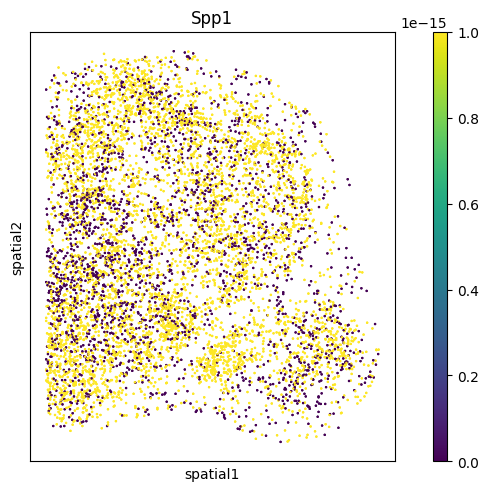

In [10]:
sq.pl.spatial_scatter(macro_data[macro_data.obs["m_type"] == "Macro_SPP1"], color="Spp1", shape=None, size=2, library_id='spatial', vmax=1e-15)

100%|██████████| 7624/7624 [00:03<00:00, 1998.45it/s]
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_color_utils.py:25: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  target.uns[color_key] = source.uns[color_key]
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


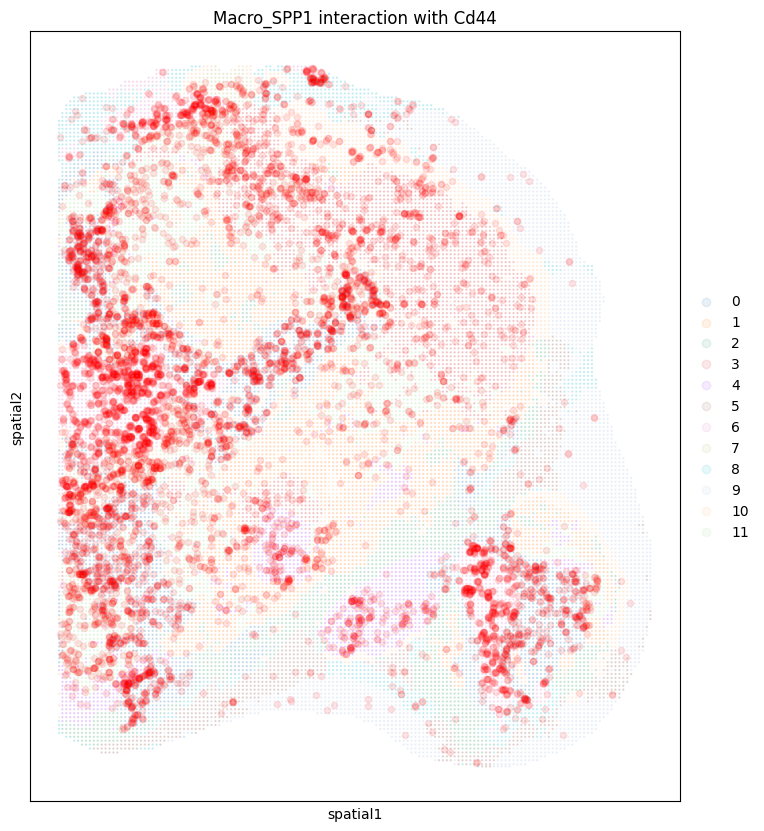

In [14]:
from sklearn.metrics import pairwise_distances
r_dict = []
ligand = "Macro_SPP1"
receptor = "Cd44"
annotation_ = annotation[annotation.obs["marker"] == "2-1"]
ligand_coord = annotation_[annotation_[:, receptor].X > 3].obsm["spatial"]
receptor_coord = macro_data[macro_data.obs["m_type"] == ligand].obsm["spatial"]

distances = pairwise_distances(ligand_coord, receptor_coord)
close = distances < 35
for i in tqdm(range(close.shape[1])):
    r_dict = r_dict + ligand_coord[close[:, i]].tolist()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
x = np.array(r_dict)[:, 0]
y = np.array(r_dict)[:, 1]
plt.scatter(x, y, s=20, alpha=0.1, color="Red")
sq.pl.spatial_scatter(fdata[fdata.obs["marker"] == "2-1"], color="cluster_cellcharter_givenk", size=2, shape=None, library_id="spatial", ax=ax, alpha=0.1)
ax.set_title(f"{ligand} interaction with {receptor}")
plt.show()

100%|██████████| 7624/7624 [00:07<00:00, 1022.76it/s]
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_color_utils.py:25: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  target.uns[color_key] = source.uns[color_key]
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


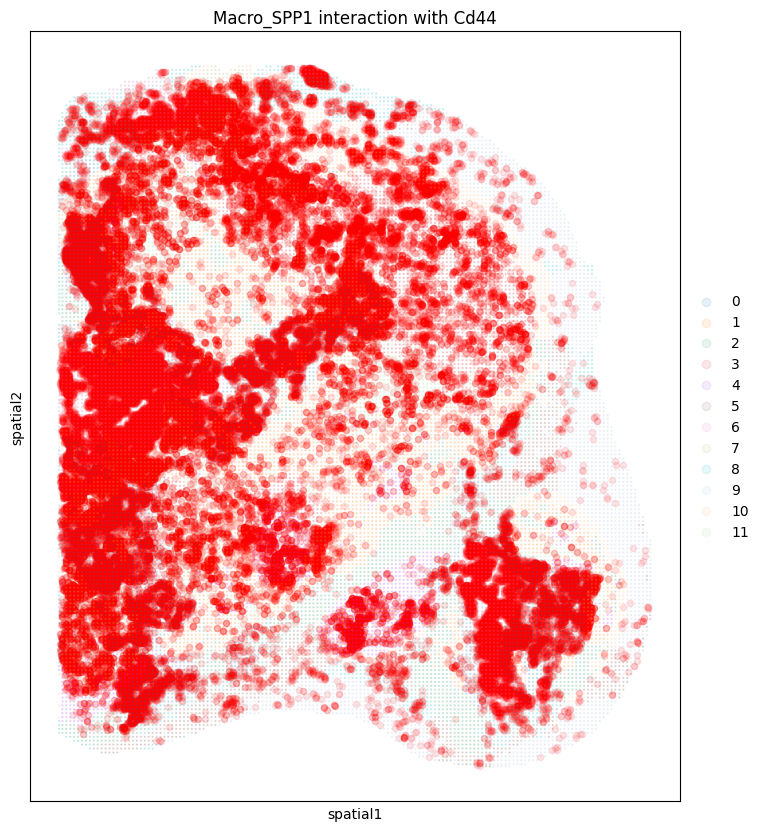

In [15]:
from sklearn.metrics import pairwise_distances
r_dict = []
ligand = "Macro_SPP1"
receptor = "Cd44"
annotation_ = annotation[annotation.obs["marker"] == "2-1"]
ligand_coord = annotation_[annotation_[:, receptor].X > 3].obsm["spatial"]
receptor_coord = macro_data[macro_data.obs["m_type"] == ligand].obsm["spatial"]

distances = pairwise_distances(ligand_coord, receptor_coord)
close = distances < 120
for i in tqdm(range(close.shape[1])):
    r_dict = r_dict + ligand_coord[close[:, i]].tolist()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
x = np.array(r_dict)[:, 0]
y = np.array(r_dict)[:, 1]
plt.scatter(x, y, s=20, alpha=0.1, color="Red")
sq.pl.spatial_scatter(fdata[fdata.obs["marker"] == "2-1"], color="cluster_cellcharter_givenk", size=2, shape=None, library_id="spatial", ax=ax, alpha=0.1)
ax.set_title(f"{ligand} interaction with {receptor}")
plt.show()

100%|██████████| 1000/1000 [00:00<00:00, 3237.49it/s]
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_color_utils.py:25: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  target.uns[color_key] = source.uns[color_key]
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


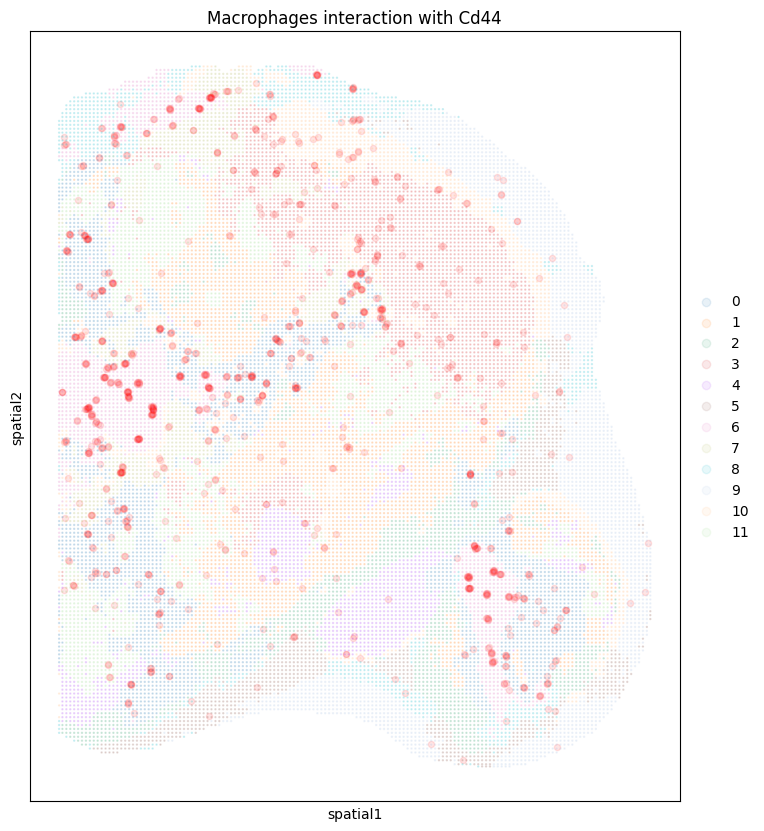

In [18]:
from sklearn.metrics import pairwise_distances
import random
r_dict = []
ligand = "Macrophages"
receptor = "Cd44"
annotation_ = annotation[annotation.obs["marker"] == "2-1"]
ligand_coord = annotation_[annotation_[:, receptor].X > 3].obsm["spatial"]
receptor_coord = annotation_[annotation_.obs["annotations"] == ligand].obsm["spatial"]
receptor_coord = receptor_coord[random.sample(range(len(receptor_coord)), 1000)]

distances = pairwise_distances(ligand_coord, receptor_coord)
close = distances < 35
for i in tqdm(range(close.shape[1])):
    r_dict = r_dict + ligand_coord[close[:, i]].tolist()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
x = np.array(r_dict)[:, 0]
y = np.array(r_dict)[:, 1]
plt.scatter(x, y, s=20, alpha=0.1, color="Red")
sq.pl.spatial_scatter(fdata[fdata.obs["marker"] == "2-1"], color="cluster_cellcharter_givenk", size=2, shape=None, library_id="spatial", ax=ax, alpha=0.1)
ax.set_title(f"{ligand} interaction with {receptor}")
plt.show()

100%|██████████| 1000/1000 [00:00<00:00, 1821.19it/s]
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_color_utils.py:25: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  target.uns[color_key] = source.uns[color_key]
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


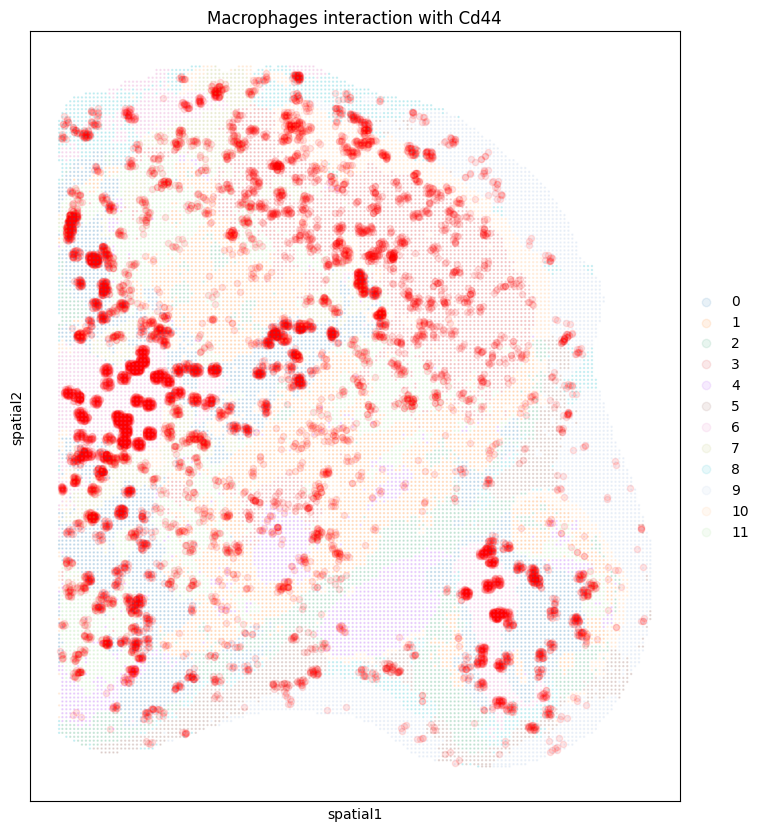

In [17]:
from sklearn.metrics import pairwise_distances
import random
r_dict = []
ligand = "Macrophages"
receptor = "Cd44"
annotation_ = annotation[annotation.obs["marker"] == "2-1"]
ligand_coord = annotation_[annotation_[:, receptor].X > 3].obsm["spatial"]
receptor_coord = annotation_[annotation_.obs["annotations"] == ligand].obsm["spatial"]
receptor_coord = receptor_coord[random.sample(range(len(receptor_coord)), 1000)]

distances = pairwise_distances(ligand_coord, receptor_coord)
close = distances < 120
for i in tqdm(range(close.shape[1])):
    r_dict = r_dict + ligand_coord[close[:, i]].tolist()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
x = np.array(r_dict)[:, 0]
y = np.array(r_dict)[:, 1]
plt.scatter(x, y, s=20, alpha=0.1, color="Red")
sq.pl.spatial_scatter(fdata[fdata.obs["marker"] == "2-1"], color="cluster_cellcharter_givenk", size=2, shape=None, library_id="spatial", ax=ax, alpha=0.1)
ax.set_title(f"{ligand} interaction with {receptor}")
plt.show()

In [ ]:
c_df = macro_data.obs[["cluster", "m_type"]].groupby("cluster").value_counts().unstack()
r_df = pd.concat([c_df.loc[[2,4,7,11]].sum(), c_df.loc[[0,1,3,5,6,8,9,10]].sum()], axis=1)
r_df.columns = ["hypoxia niche", "others"]

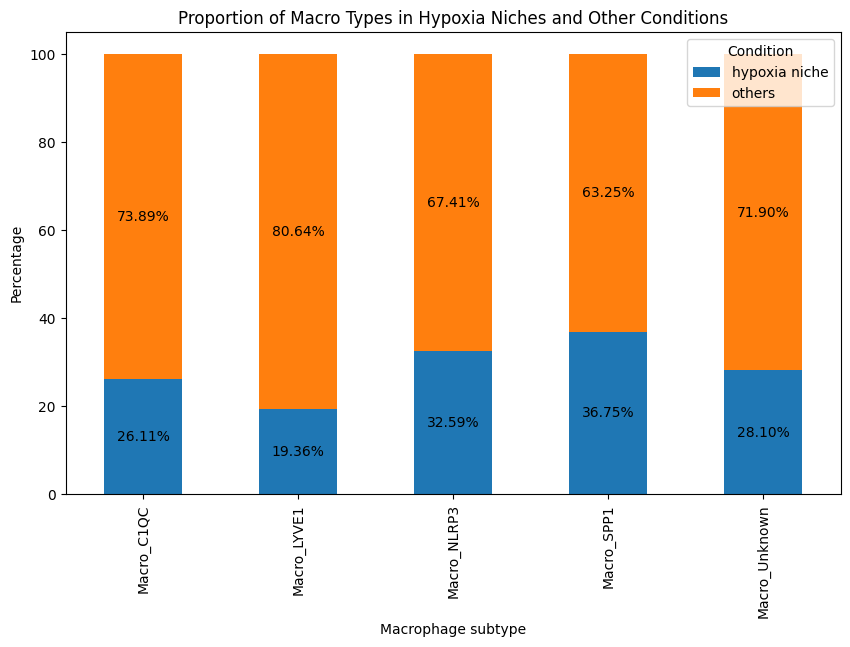

In [12]:
# Calculate the percentage
df_percentage = r_df.div(r_df.sum(axis=1), axis=0) * 100

# Plot the data
ax = df_percentage.plot(kind='bar', stacked=True, figsize=(10, 6))

# Set plot labels and title
ax.set_ylabel('Percentage')
ax.set_xlabel('Macrophage subtype')
ax.set_title('Proportion of Macro Types in Hypoxia Niches and Other Conditions')
ax.legend(title='Condition')

# Add percentage labels on top of the bars
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2f}%', (x + width / 2, y + height / 2), ha='center', va='center')

plt.show()

### Macrophage与T互作分布

In [61]:
r_dict = {}
t_types = np.unique(annotation_.obs["annotations"][annotation_.obs["annotations"].str.endswith("T")])
for cluster in tqdm(np.unique(annotation_.obs["cluster"])):
        annotation__ = annotation_[annotation_.obs["cluster"] == cluster]
        t_cell_idx = np.where(annotation__.obs["annotations"].str.endswith("T"))[0]
        m_cell_idx = np.where(annotation__.obs["annotations"] == "Macrophages")[0]
        coords = annotation__.obsm["spatial"]

        distances = pairwise_distances(coords[t_cell_idx], coords[m_cell_idx])
        interactions = np.sum(distances < 30)
        r_dict[cluster] = interactions / len(t_cell_idx) / len(m_cell_idx)

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:19<00:00,  1.66s/it]


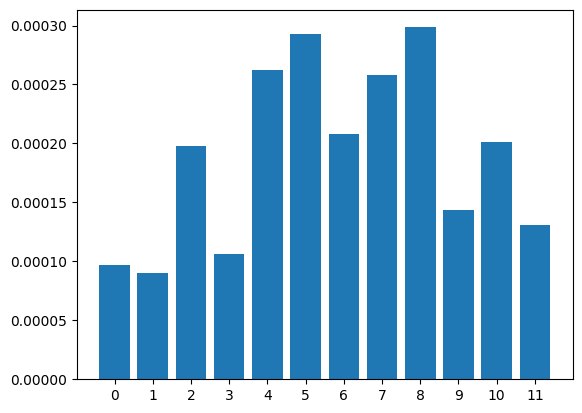

In [83]:
r_df = pd.DataFrame(r_dict, index=["frequency"]).T
r_df.index = r_df.index.astype(int)
r_df.sort_values(by="frequency", inplace=True)
plt.bar(x=r_df.index, height=r_df.frequency)
plt.xticks(range(0, 12))
plt.show()

In [13]:
r_dict = {}
t_types = np.unique(annotation_.obs["annotations"][annotation_.obs["annotations"].str.endswith("T")])
for cluster in tqdm(np.unique(annotation_.obs["cluster"])):
    r_dict[cluster] = {}
    for m_type in np.unique(macro_data.obs["m_type"]):
        annotation__ = annotation_[annotation_.obs["cluster"] == cluster]
        t_cell_idx = np.where(annotation__.obs["annotations"].str.endswith("T"))[0]
        m_cell_idx = np.where(macro_data[macro_data.obs["cluster"] == cluster].obs["m_type"] == m_type)[0]
        t_coords = annotation__.obsm["spatial"]
        m_coords = macro_data.obsm["spatial"]

        distances = pairwise_distances(t_coords[t_cell_idx], m_coords[m_cell_idx])
        interactions = np.sum(distances < 30)
        r_dict[cluster][m_type] = interactions / len(t_cell_idx) / len(m_cell_idx)

100%|██████████| 12/12 [00:24<00:00,  2.04s/it]


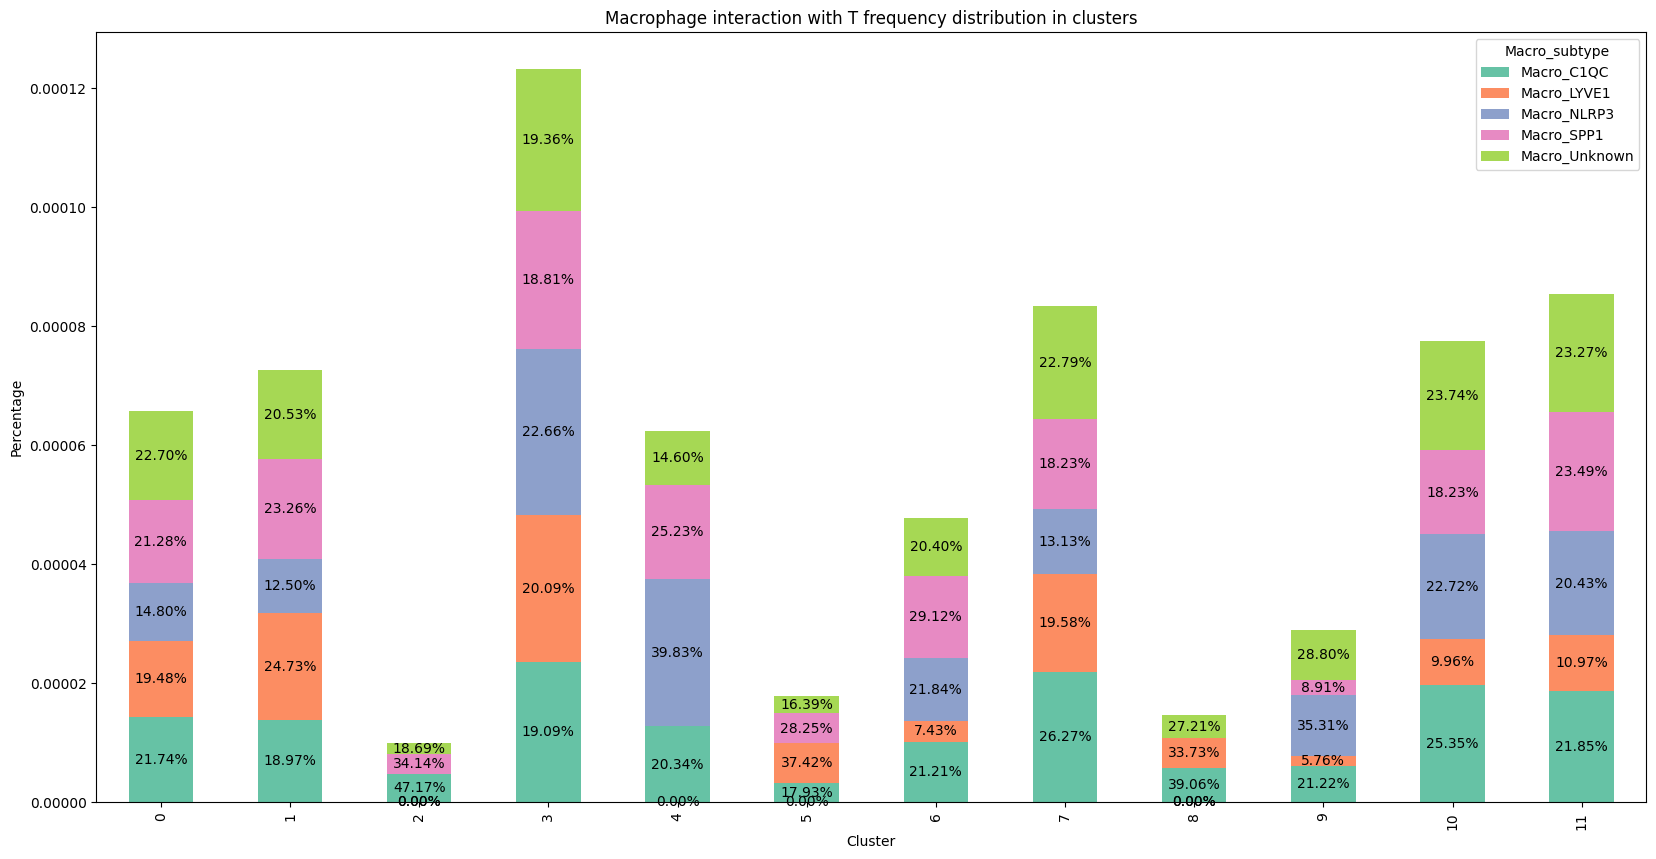

In [18]:
r_df = pd.DataFrame(r_dict, columns=range(0, 12)).T
df_percentage = r_df.div(r_df.sum(axis=1), axis=0) * 100

cmap = plt.get_cmap('Set2')
colors = [cmap(i) for i in range(len(r_df.columns))]

# Plot the data
#ax = df_percentage.plot(kind='bar', stacked=True, figsize=(10, 6))
ax = r_df.plot(kind='bar', stacked=True, figsize=(20, 10), color=colors)

# Set plot labels and title
ax.set_ylabel('Percentage')
ax.set_xlabel('Cluster')
ax.set_title('Macrophage interaction with T frequency distribution in clusters')
ax.legend(title='Macro_subtype')

# Add percentage labels on top of the bars
cnt = 0
ep = 0
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    cnt += 1
    ax.annotate(f'{df_percentage.iloc[int(x+0.3), ep]:.2f}%', (x + width / 2, y + height / 2), ha='center', va='center')
    if cnt == 12:
        cnt = 0
        ep += 1
plt.show()

In [99]:
r_dict = {}
t_types = np.unique(annotation_.obs["annotations"][annotation_.obs["annotations"].str.endswith("T")])
for cluster in tqdm(np.unique(annotation_.obs["cluster"])):
    r_dict[cluster] = {}
    for m_type in np.unique(macro_data.obs["m_type"]):
        annotation__ = annotation_[annotation_.obs["cluster"] == cluster]
        t_cell_idx = np.where(annotation__.obs["annotations"].str.endswith("T"))[0]
        m_cell_idx = np.where(macro_data[macro_data.obs["cluster"] == cluster].obs["m_type"] == m_type)[0]
        t_coords = annotation__.obsm["spatial"]
        m_coords = macro_data.obsm["spatial"]

        distances = pairwise_distances(t_coords[t_cell_idx], m_coords[m_cell_idx])
        close = distances < 30
        for i in range(close.shape[1]):
            try:
                r_dict[cluster][m_type] = np.append(r_dict[cluster][m_type], np.array(t_coords[t_cell_idx][close[:, i]]), axis=0)
            except:
                r_dict[cluster][m_type] = np.array(t_coords[t_cell_idx][close[:, i]])

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [01:00<00:00,  5.01s/it]


/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


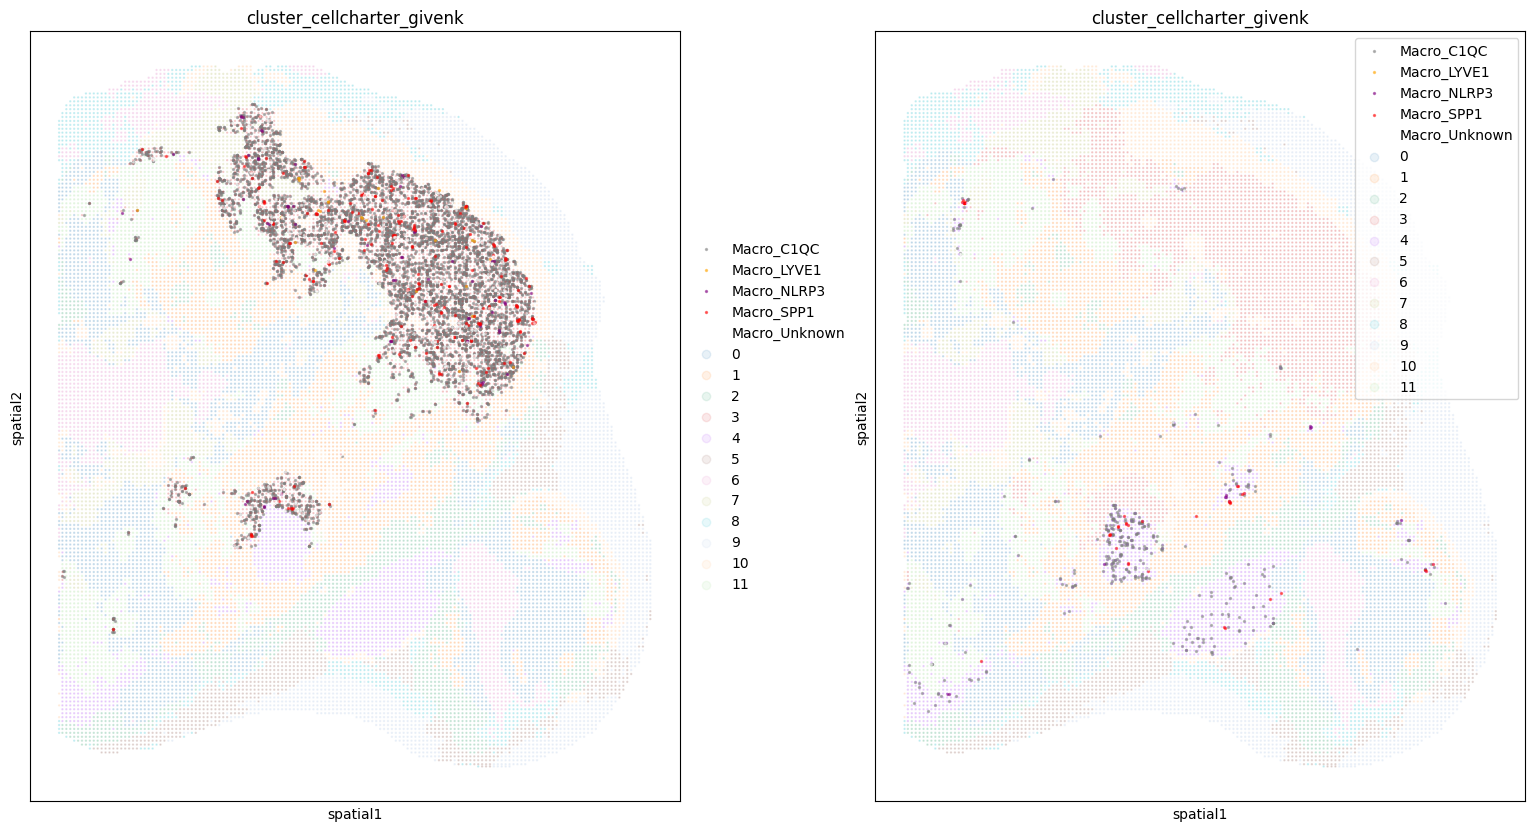

In [107]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
color_map = {
    'Macro_Unknown': 'White',
    'Macro_LYVE1': 'Orange',
    'Macro_SPP1': 'Red',
    'Macro_NLRP3': 'Purple',
    'Macro_C1QC': 'Grey'
}
for m_type, coords in r_dict[3.0].items():
    x = coords[:, 0]
    y = coords[:, 1]
    ax[0].scatter(x, y, s=2, alpha=0.5, color=color_map[m_type], label=m_type)
for m_type, coords in r_dict[4.0].items():
    x = coords[:, 0]
    y = coords[:, 1]
    ax[1].scatter(x, y, s=2, alpha=0.5, color=color_map[m_type], label=m_type)
sq.pl.spatial_scatter(fdata_, color="cluster_cellcharter_givenk", size=2, shape=None, library_id="spatial", ax=ax[0], alpha=0.1)
sq.pl.spatial_scatter(fdata_, color="cluster_cellcharter_givenk", size=2, shape=None, library_id="spatial", ax=ax[1], alpha=0.1)
plt.legend()
plt.show()

### Cluster3作为焦点

In [119]:
r_dict = {}
t_types = np.unique(annotation_.obs["annotations"][annotation_.obs["annotations"].str.endswith("T")])
annotation__ = annotation_[annotation_.obs["cluster"] == 3.0]
t_coords = annotation__.obsm["spatial"]
m_coords = macro_data[macro_data.obs["cluster"] == 3.0].obsm["spatial"]
for t_type in np.unique(t_types):
    t_cell_idx = np.where(annotation__.obs["annotations"] == t_type)[0]
    r_dict[t_type] = {}
    for m_type in np.unique(macro_data.obs["m_type"]):
        m_cell_idx = np.where(macro_data[macro_data.obs["cluster"] == 3.0].obs["m_type"] == m_type)[0]
        if len(t_cell_idx) == 0 or len(m_cell_idx) == 0:
            r_dict[t_type][m_type] = 0
            continue
        distances = pairwise_distances(t_coords[t_cell_idx], m_coords[m_cell_idx])
        interactions = np.sum(distances < 30)
        r_dict[t_type][m_type] = interactions / len(t_cell_idx) / len(m_cell_idx)

In [121]:
pd.DataFrame(r_dict)

Unknown T  effector T  exhausted T  memory T  stem-like T
Macro_C1QC      0.000105    0.000109     0.000110  0.000106     0.000104
Macro_LYVE1     0.000080    0.000076     0.000112  0.000109     0.000104
Macro_NLRP3     0.000100    0.000101     0.000178  0.000103     0.000106
Macro_SPP1      0.000113    0.000125     0.000119  0.000113     0.000082
Macro_Unknown   0.000111    0.000094     0.000095  0.000091     0.000108

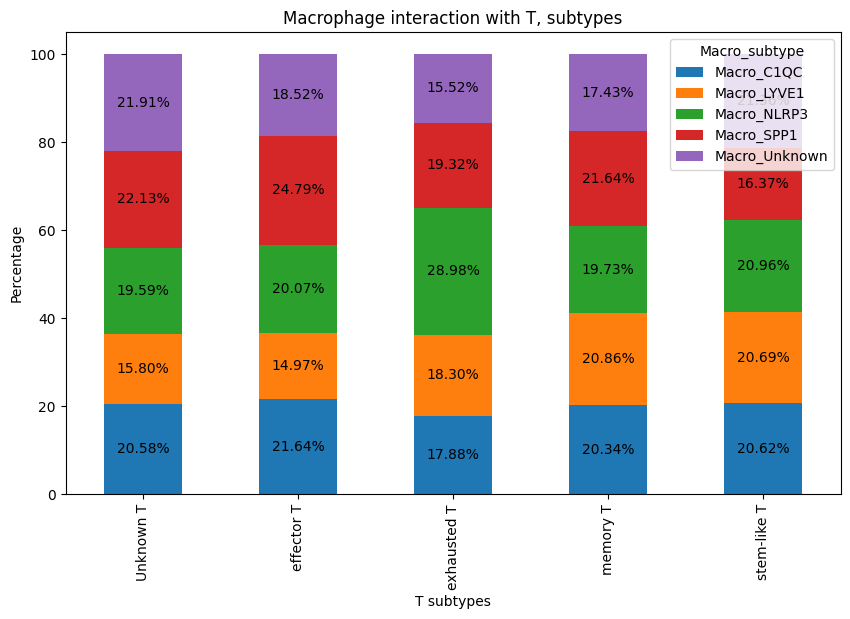

In [125]:
r_df = pd.DataFrame(r_dict).T
df_percentage = r_df.div(r_df.sum(axis=1), axis=0) * 100

# Plot the data
ax = df_percentage.plot(kind='bar', stacked=True, figsize=(10, 6))
#ax = r_df.plot(kind='bar', stacked=True, figsize=(10, 6))

# Set plot labels and title
ax.set_ylabel('Percentage')
ax.set_xlabel('T subtypes')
ax.set_title('Macrophage interaction with T, subtypes')
ax.legend(title='Macro_subtype')

# Add percentage labels on top of the bars
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2f}%', (x + width / 2, y + height / 2), ha='center', va='center')

plt.show()

### Exhaust score between interaction T with macrophage

We randomly select bins with / without interaction of T and macrophage, and compare exhaustion score between them.

In [13]:
import random

In [40]:
# random select 1000 bins
selected_index = random.sample(annotation_.obs_names.tolist(), 200)
random_data = annotation_[selected_index]

In [32]:
r_dict = {}
t_types = np.unique(annotation_.obs["annotations"][annotation_.obs["annotations"].str.endswith("T")])
cluster = 3.0
for m_type in tqdm(np.unique(macro_data.obs["m_type"])):
    annotation__ = annotation_[annotation_.obs["cluster"] == cluster]
    t_cell_idx = np.where(annotation__.obs["annotations"].str.endswith("T"))[0]
    m_cell_idx = np.where(macro_data[macro_data.obs["cluster"] == cluster].obs["m_type"] == m_type)[0]
    t_coords = annotation__.obsm["spatial"]
    m_coords = macro_data.obsm["spatial"]

    distances = pairwise_distances(t_coords[t_cell_idx], m_coords[m_cell_idx])
    close = distances < 25
    for i in range(close.shape[1]):
        try:
            r_dict[m_type] = np.append(r_dict[m_type], np.array(annotation__[t_cell_idx].obs_names[close[:, i]]), axis=0)
        except:
            r_dict[m_type] = np.array(annotation__[t_cell_idx].obs_names[close[:, i]])

In [27]:
#exhaust_genes = ['Cd8a','Cd8b1', "Lag3", "Pdcd1", "Tigit", "Ctla4", 'Tox','Tnfrsf9','Tnfrsf18',  'Cxcr6', 'Cxcl13']
exhaust_genes = ['Cd8a', 'Cd8b1', 'Pdcd1', 'Tnfrsf9']

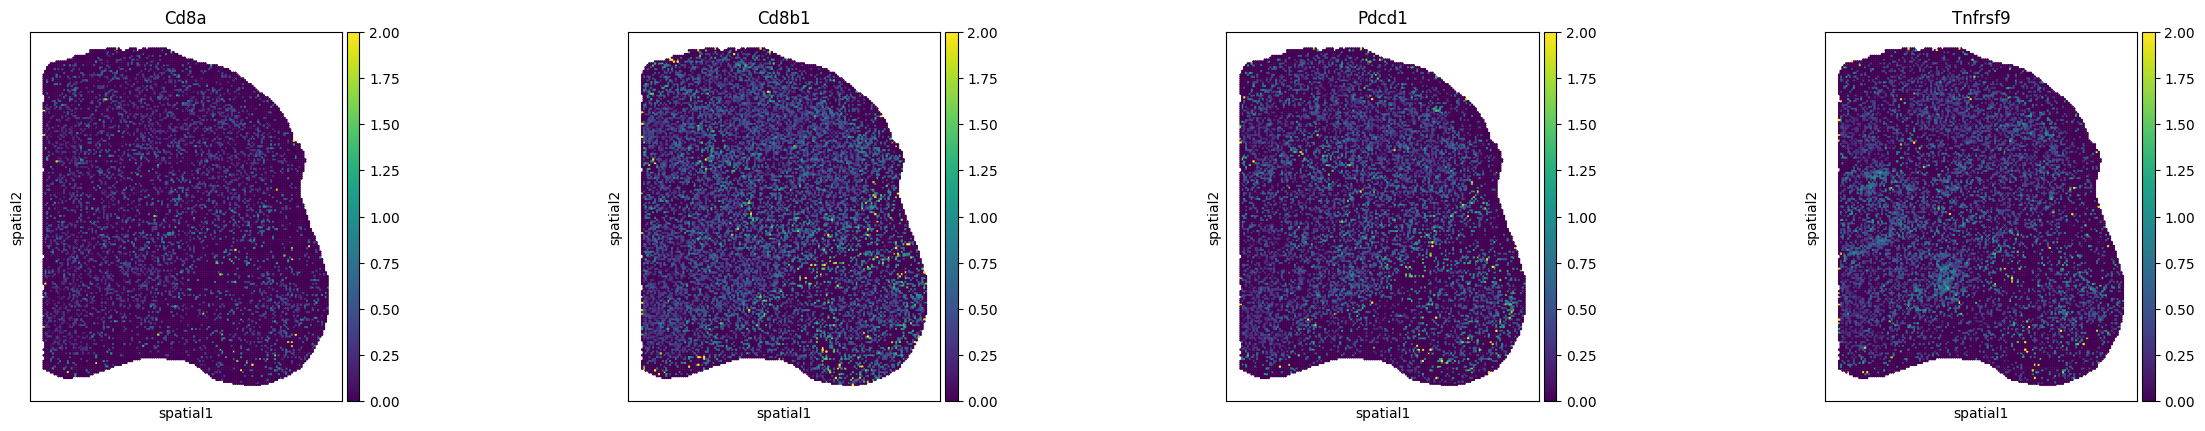

In [48]:
sq.pl.spatial_scatter(fdata_, color=exhaust_genes, size=2, shape=None, library_id="spatial", vmax=2)

In [49]:
exh_scores = {}
for m_type in tqdm(r_dict):
    interact_data = annotation_[r_dict[m_type]].copy()
    bin100_data = utils.extract_big_bin(fdata, interact_data)
    sc.tl.score_genes(bin100_data, gene_list=exhaust_genes, score_name="score")
    exh_scores[m_type] = bin100_data.obs["score"].tolist()
    #exh_scores[m_type] = np.array(interact_data[:, exhaust_genes].X.mean(axis=1)).flatten()

  0%|          | 0/5 [00:00<?, ?it/s]/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


 80%|████████  | 4/5 [00:04<00:00,  1.14it/s]/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


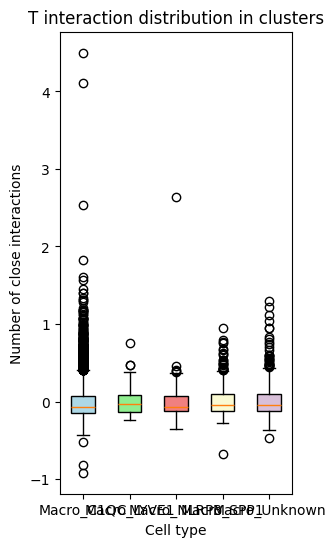

In [51]:
fig, ax = plt.subplots(figsize=(3, 6))
box = ax.boxplot(exh_scores.values(), patch_artist=True)

colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightgoldenrodyellow', 'thistle']

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xticklabels(exh_scores.keys())

ax.set_title("T interaction distribution in clusters")
ax.set_xlabel("Cell type")
ax.set_ylabel("Number of close interactions")

plt.show()

In [56]:
print(f_oneway(exh_scores["Macro_C1QC"], exh_scores["Macro_SPP1"]))
print(np.mean(exh_scores["Macro_C1QC"]), np.mean(exh_scores["Macro_SPP1"]))

F_onewayResult(statistic=7.772350370046388, pvalue=0.005314823192160767)
-0.01268714163147572 0.012076050929099197


In [53]:
exh_scores.values()

dict_values([[-0.101625176777287, 0.07491604851679509, -0.09093277485704002, -0.13606963740142444, -0.18741625348707416, 0.13892214484333967, -0.04456023430720317, -0.01793868471106655, -0.04923108315353855, -0.05825209841001408, -0.05223125069792767, -0.045375370926547934, 0.022608556118810352, -0.058120050944181004, 0.04237395233121724, 0.07252328072531924, -0.08137578062175344, 0.05982383741268471, 0.15690967283377252, -0.1163860443060186, -0.15084163057953853, 0.05827486299533177, -0.20709341408256152, -0.03931404867300875, -0.1103237021215722, -0.009526928049882644, -0.1126389357634093, -0.014941909724138197, -0.04005854112830806, 0.00793489695996169, 0.0159627504821144, 0.13989725236060804, -0.10464795613492726, -0.06974117577879056, -0.032445642058154534, -0.1115395732384774, -0.18911252211931842, -0.06548445700032446, -0.00980906516747973, -0.02329428877107112, -0.12988645168687654, 0.09532603801098069, -0.11719202020569133, 0.08531419447386207, 0.07873455168572202, 0.039001277

[-0.101625176777287, 0.07491604851679509, -0.09093277485704002, -0.13606963740142444, -0.18741625348707416, 0.13892214484333967, -0.04456023430720317, -0.01793868471106655, -0.04923108315353855, -0.05825209841001408, -0.05223125069792767, -0.045375370926547934, 0.022608556118810352, -0.058120050944181004, 0.04237395233121724, 0.07252328072531924, -0.08137578062175344, 0.05982383741268471, 0.15690967283377252, -0.1163860443060186, -0.15084163057953853, 0.05827486299533177, -0.20709341408256152, -0.03931404867300875, -0.1103237021215722, -0.009526928049882644, -0.1126389357634093, -0.014941909724138197, -0.04005854112830806, 0.00793489695996169, 0.0159627504821144, 0.13989725236060804, -0.10464795613492726, -0.06974117577879056, -0.032445642058154534, -0.1115395732384774, -0.18911252211931842, -0.06548445700032446, -0.00980906516747973, -0.02329428877107112, -0.12988645168687654, 0.09532603801098069, -0.11719202020569133, 0.08531419447386207, 0.07873455168572202, 0.0390012777558707, -0.0

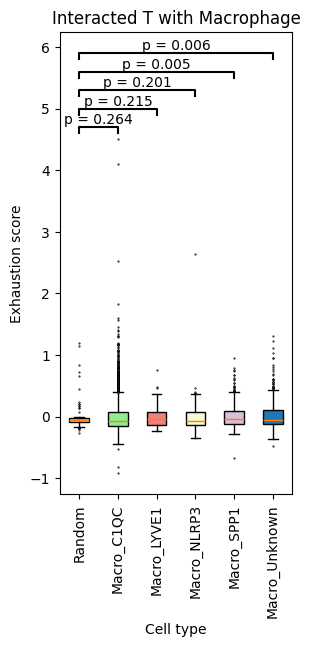

In [90]:
sc.tl.score_genes(random_data, gene_list=exhaust_genes, score_name="score")
vec = [random_data.obs["score"].tolist()]
for value in exh_scores.values():
    vec.append(value)
print(vec[1])

fig, ax = plt.subplots(figsize=(3, 6))
box = ax.boxplot(vec, patch_artist=True, flierprops=dict(marker='.', markerfacecolor='w', markersize=1, linestyle='none'))

colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightgoldenrodyellow', 'thistle']

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xticks([1, 2, 3, 4, 5, 6])
ax.set_xticklabels(["Random"] + [key for key in exh_scores.keys()], rotation=90)

ax.set_title("Interacted T with Macrophage")
ax.set_xlabel("Cell type")
ax.set_ylabel("Exhaustion score")

spp1_a = f_oneway(vec[0], exh_scores["Macro_SPP1"])
nlrp3_a = f_oneway(vec[0], exh_scores["Macro_NLRP3"])
lyve1_a = f_oneway(vec[0], exh_scores["Macro_LYVE1"])
c1qc_a = f_oneway(vec[0], exh_scores["Macro_C1QC"])
unknown_a = f_oneway(vec[0], exh_scores["Macro_Unknown"])

x1, x2, x3, x4, x5, x6 = 1, 2, 3, 4, 5, 6
h, col = 0.1, 'k'
max_ = np.max(vec[1])
y2, y3, y4, y5, y6 = max_ + 0.1, max_ + 0.4, max_ + 0.7, max_ + 1, max_ + 1.3
ax.plot([x1, x1, x2, x2], [y2, y2 + h, y2 + h, y2], lw=1.5, c=col)
ax.plot([x1, x1, x3, x3], [y3, y3 + h, y3 + h, y3], lw=1.5, c=col)
ax.plot([x1, x1, x4, x4], [y4, y4 + h, y4 + h, y4], lw=1.5, c=col)
ax.plot([x1, x1, x5, x5], [y5, y5 + h, y5 + h, y5], lw=1.5, c=col)
ax.plot([x1, x1, x6, x6], [y6, y6 + h, y6 + h, y6], lw=1.5, c=col)
ax.text((x1 + x5) * .5, y5 + h, f"p = {spp1_a[1]:.3f}", ha='center', va='bottom', color=col)
ax.text((x1 + x4) * .5, y4 + h, f"p = {nlrp3_a[1]:.3f}", ha='center', va='bottom', color=col)
ax.text((x1 + x3) * .5, y3 + h, f"p = {lyve1_a[1]:.3f}", ha='center', va='bottom', color=col)
ax.text((x1 + x2) * .5, y2 + h, f"p = {c1qc_a[1]:.3f}", ha='center', va='bottom', color=col)
ax.text((x1 + x6) * .5, y6 + h, f"p = {unknown_a[1]:.3f}", ha='center', va='bottom', color=col)

plt.show()

In [102]:
test_data.obs

marker  annotations              cov  cluster  Macro_SPP1_score  \
163107-1    2-1  Macrophages     2-1_3600-600      7.0         -0.093333   
161327-1    2-1  Macrophages     2-1_3600-900      6.0         -0.146667   
121069-1    2-1  Macrophages    2-1_2700-2100      3.0         -0.086667   
18948-1     2-1  Macrophages     2-1_400-2600      2.0         -0.013333   
238488-1    2-1  Macrophages    2-1_5300-3000      3.0         -0.153333   
...         ...          ...              ...      ...               ...   
617958-1    2-1  Macrophages  2-1_13700-12200      1.0          0.000000   
180292-1    2-1  Macrophages    2-1_4000-3900      1.0          0.000000   
603582      2-1  Macrophages  2-1_13400-11400     10.0          0.000000   
8430-1      2-1  Macrophages     2-1_100-7300     10.0          0.000000   
247301-1    2-1  Macrophages       2-1_5500-0      8.0          0.000000   

          Macro_NLRP3_score  Macro_LYVE1_score  Macro_C1QC_score  \
163107-1          -0.006667          -0.006667          0.546667   
161327-1          -0.006667          -0.006667          1.900000   
121069-1          -0.006667          -0.006667          1.680000   
18948-1            0.000000           0.000000         -0.060000   
238488-1          -0.020000          -0.020000          2.873333   
...                     ...                ...               ...   
617958-1           0.000000           0.000000         -0.020000   
180292-1           0.000000           0.000000          0.000000   
603582             0.000000           0.000000          0.000000   
8430-1             0.333333           0.000000          0.000000   
247301-1           0.000000           0.000000          0.000000   

                 m_type Unknown  
163107-1     Macro_C1QC   False  
161327-1     Macro_C1QC   False  
121069-1     Macro_C1QC   False  
18948-1   Macro_Unknown   False  
238488-1     Macro_C1QC   False  
...                 ...     ...  
617958-1  Macro_Unknown   False  
180292-1  Macro_Unknown   False  
603582    Macro_Unknown   False  
8430-1      Macro_NLRP3   False  
247301-1  Macro_Unknown   False  

[235275 rows x 10 columns]

In [103]:
test_data = macro_data.copy()
test_data.obs["Unknown"] = False
test_data.obs["Unknown"][test_data.obs["m_type"] == "Macro_Unknown"] = True
test_data.obs["Unknown"] = test_data.obs["Unknown"].astype("category")
sc.tl.rank_genes_groups(test_data, groupby="Unknown", method='t-test')

/tmp/ipykernel_68022/2014736182.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  test_data.obs["Unknown"][test_data.obs["m_type"] == "Macro_Unknown"] = True
/tmp/ipykernel_68022/2014736182.py:3: SettingWithCopyWarning: 
A value is trying 

In [130]:
f = open("genes.txt", 'w')
deg_list = pd.DataFrame(pd.DataFrame(test_data.uns["rank_genes_groups"]["names"][:50]).loc[:, "True"])
deg_list.to_csv("genes.txt", index=False)

### sgCd44 and Spp1+ Macrophage

In [23]:
cdata_ = utils.combine_guide_replicates(cdata_)

/home/wpy/stereoseq/20240502-SPACseq/bin/utils.py:78: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


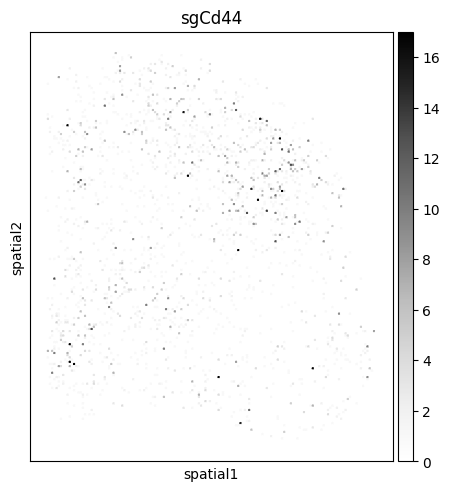

In [137]:
sq.pl.spatial_scatter(cdata_, color="sgCd44", shape=None, size=2, cmap="Greys", library_id="spatial", vmax=17)

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


Text(0.5, 1.0, 'sgCd44 Perturbed T')

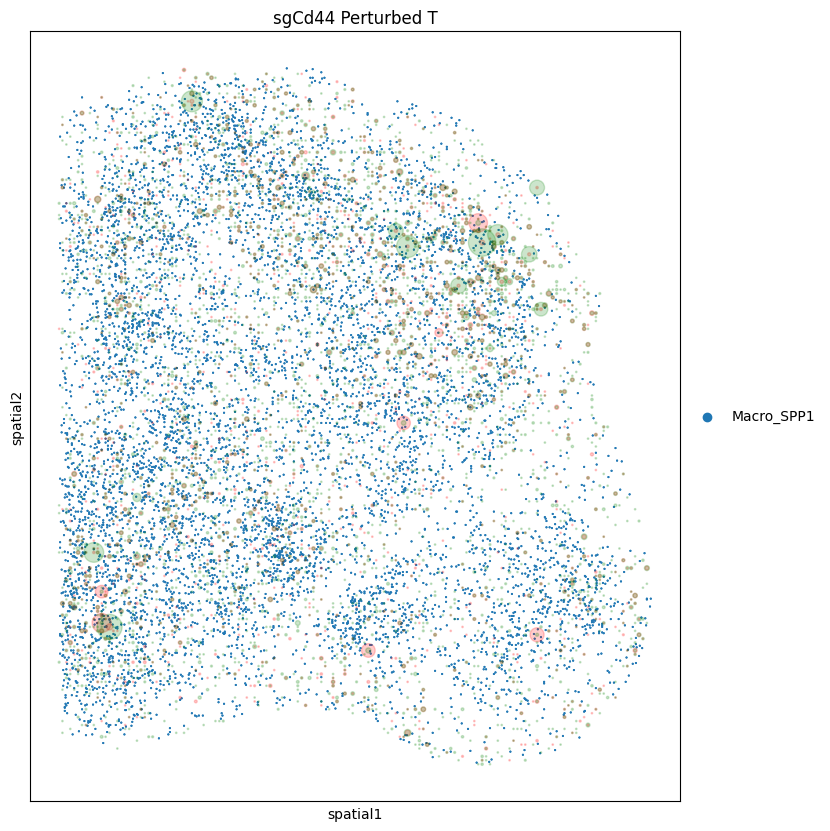

In [150]:
fig, ax=plt.subplots(1, 1, figsize=(10, 10))
sq.pl.spatial_scatter(macro_data[macro_data.obs["m_type"] == "Macro_SPP1"], color="m_type", shape=None, size=1, cmap="Greys", library_id="spatial", vmax=17, ax=ax)
utils.plot_dot(cdata_, gene_name="sgCd44", ax=ax, square=False, color="Red")
utils.plot_dot(cdata_, gene_name="sgNTC", ax=ax, square=False, color="Green")
ax.set_title("sgCd44 Perturbed T")
#ax.invert_yaxis()

In [13]:
annotation_guide_.obs["cluster"] = annotation_.obs["cluster"].tolist()

In [168]:
annotation_guide__[:, guide].X.toarray() > 2

array([], shape=(0, 1), dtype=bool)

In [21]:
# compared with sgNTC, Spp1+ Macro ~ sgCd44 interacted T cells showed less exhaustion
r_dict = {}
annotation__ = annotation_[annotation_.obs["cluster"] == 3.0]
annotation_guide__ = annotation_guide_[annotation_guide_.obs["cluster"] == 3.0]
t_coords = annotation_guide__.obsm["spatial"]
m_coords = macro_data[macro_data.obs["cluster"] == 3.0].obsm["spatial"]
for guide in tqdm(annotation_guide_.var_names):
    r_dict[guide] = {}
    t_cell_idx = np.where(annotation_guide__[:, guide].X.toarray() > 2)[0]
    for m_type in np.unique(macro_data.obs["m_type"]):
        m_cell_idx = np.where(macro_data[macro_data.obs["cluster"] == 3.0].obs["m_type"] == m_type)[0]
        if len(t_cell_idx) == 0 or len(m_cell_idx) == 0:
            r_dict[guide][m_type] = 0
            continue
        distances = pairwise_distances(t_coords[t_cell_idx], m_coords[m_cell_idx])
        interactions = np.sum(distances < 125)
        r_dict[guide][m_type] = interactions / len(m_cell_idx)

100%|██████████| 34/34 [00:11<00:00,  3.08it/s]


In [187]:
pd.DataFrame(r_dict)[["sgZc3h12a", "sgCd44", "sgNTC"]]

sgZc3h12a    sgCd44     sgNTC
Macro_C1QC      0.034065  0.011115  0.019025
Macro_LYVE1     0.066667  0.033333  0.040000
Macro_NLRP3     0.037162  0.020270  0.027027
Macro_SPP1      0.024626  0.007916  0.009675
Macro_Unknown   0.027532  0.006391  0.012291

0.4943006356424563


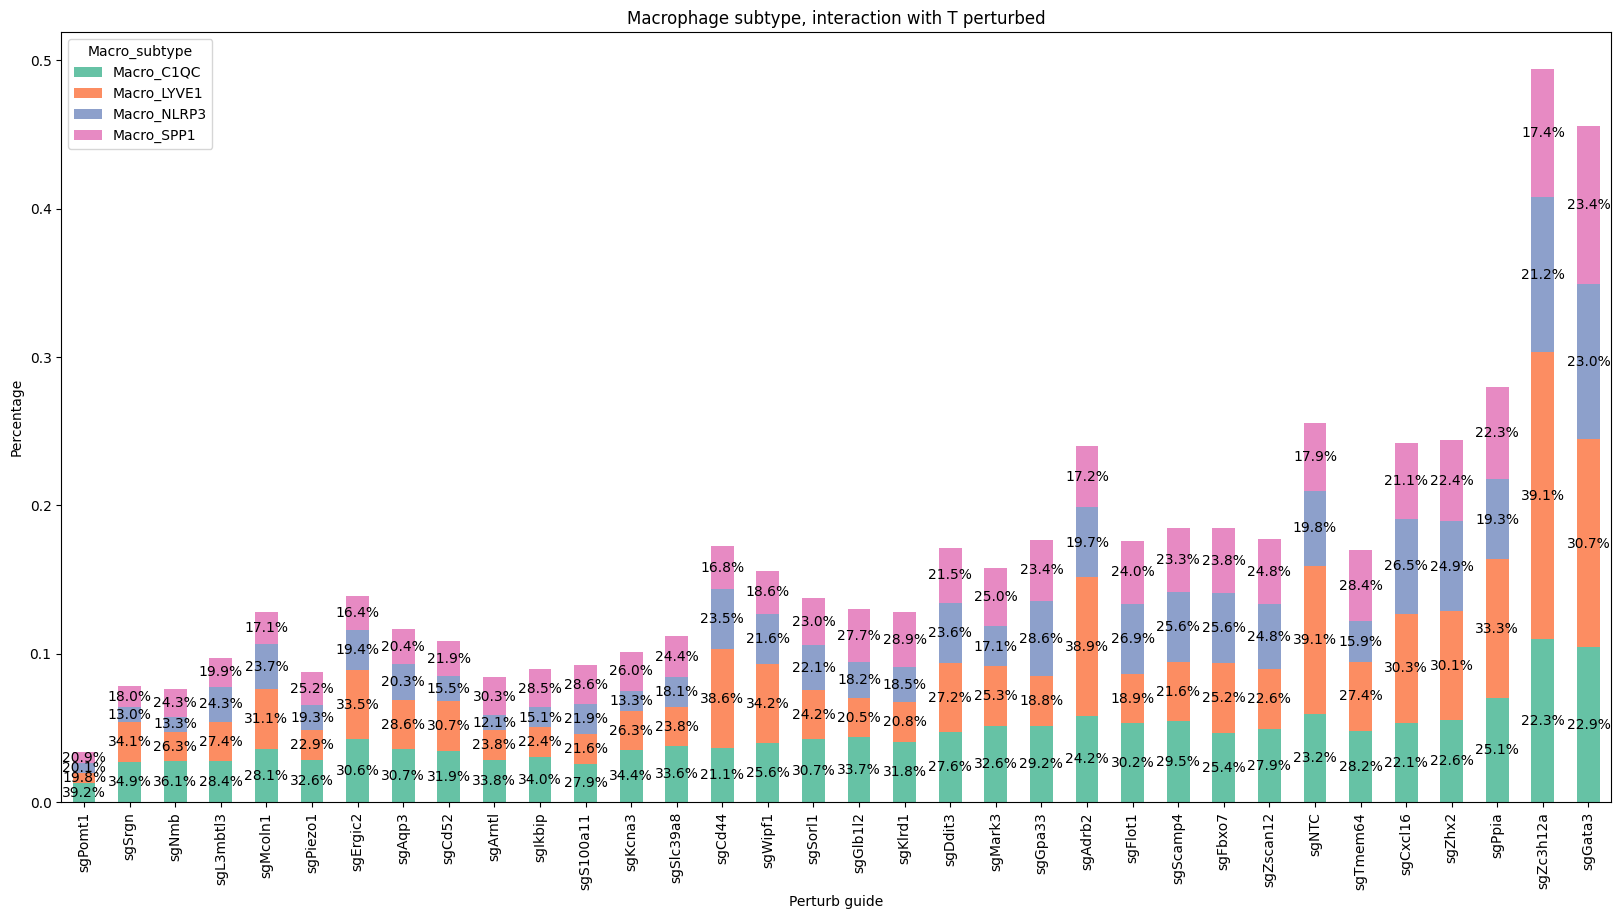

In [22]:
r_df = pd.DataFrame(r_dict).T
r_df = r_df.iloc[:, :-1]
r_df.sort_values(by="Macro_SPP1", ascending=True, inplace=True)
df_percentage = r_df.div(r_df.sum(axis=1), axis=0) * 100

cmap = plt.get_cmap('Set2')
colors = [cmap(i) for i in range(len(r_df.columns))]

# Plot the data
#ax = df_percentage.plot(kind='bar', stacked=True, figsize=(20, 10))
ax = r_df.plot(kind='bar', stacked=True, figsize=(20, 10), color=colors)

# Set plot labels and title
ax.set_ylabel('Percentage')
ax.set_xlabel('Perturb guide')
ax.set_title('Macrophage subtype, interaction with T perturbed')
ax.legend(title='Macro_subtype', loc='upper left')

max_ = r_df.sum(axis=1).max()
print(max_)

# Add percentage labels on top of the bars
cnt = 0
ep = 0
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    cnt += 1
    ax.annotate(f'{df_percentage.iloc[int((x+0.3) // 1), ep]:.1f}%', (x + width / 2, y + height / 2), ha='center', va='center')
    if cnt == 34:
        ep += 1
        cnt = 0
plt.show()

### sgCd44 interaction with Spp1 Macrophage cause less exhaustion

In [63]:
r_dict = {}
annotation__ = annotation_[annotation_.obs["cluster"] == 3.0]
annotation_guide__ = annotation_guide_[annotation_guide_.obs["cluster"] == 3.0]
t_coords = annotation_guide__.obsm["spatial"]
m_coords = macro_data[macro_data.obs["cluster"] == 3.0].obsm["spatial"]
# annotation__ = annotation_.copy()
# annotation_guide__ = annotation_guide_.copy()
# t_coords = annotation_guide__.obsm["spatial"]
# m_coords = macro_data.obsm["spatial"]
for guide in tqdm(annotation_guide_.var_names):
    r_dict[guide] = {}
    t_cell_idx = np.where(annotation_guide__[:, guide].X.toarray() > 2)[0]
    if guide != "sgNTC" and guide != "sgCd44" and guide != "sgGata3": continue
    for m_type in np.unique(macro_data.obs["m_type"]):
        if m_type != "Macro_SPP1": continue
        m_cell_idx = np.where(macro_data[macro_data.obs["cluster"] == 3.0].obs["m_type"] == m_type)[0]
        if len(t_cell_idx) == 0 or len(m_cell_idx) == 0:
            r_dict[guide][m_type] = 0
            continue
        distances = pairwise_distances(t_coords[t_cell_idx], m_coords[m_cell_idx])
        close = distances < 35
        for i in range(close.shape[1]):
            try:
                r_dict[guide][m_type] = np.append(r_dict[guide][m_type], np.array(annotation_guide__[t_cell_idx].obs_names[close[:, i]]), axis=0)
            except:
                r_dict[guide][m_type] = np.array(annotation_guide__[t_cell_idx].obs_names[close[:, i]])

100%|██████████| 34/34 [00:07<00:00,  4.84it/s]


In [64]:
exh_scores = {}
for guide in tqdm(annotation_guide_.var_names):
    if guide != "sgNTC" and guide != "sgCd44" and guide != "sgGata3": continue
    interact_data = annotation_guide_[r_dict[guide]["Macro_SPP1"]].copy()
    bin100_data = utils.extract_big_bin(fdata, interact_data)
    sc.tl.score_genes(bin100_data, gene_list=exhaust_genes, score_name="score")
    #exh_scores[guide] = bin100_data.obs["score"].tolist()
    exh_scores[guide] = np.array(bin100_data[:, exhaust_genes].X.mean(axis=1)).flatten()

  0%|          | 0/34 [00:00<?, ?it/s]

100%|██████████| 34/34 [00:00<00:00, 36.25it/s]


In [42]:
exh_scores

{}

In [29]:
# random select 1000 bins
import random
selected_index = random.sample(annotation__.obs_names.tolist(), 20)
random_data = annotation__[selected_index]

sgCd44
0.17132572243137503
sgGata3
0.13922990960405576
sgNTC
0.1279387659404059


Text(1.5, 0.6467927041988064, 'p = 0.817')

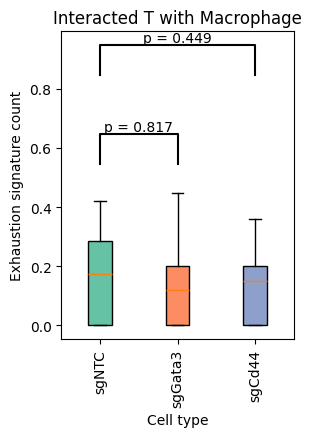

In [65]:
sc.tl.score_genes(random_data, gene_list=exhaust_genes, score_name="score")
vec = []

for key, value in exh_scores.items():
    if key not in ["sgNTC", "sgCd44", "sgGata3"]: continue
    else: print(key)
    print(np.mean(value))
    vec.append(value)

fig, ax = plt.subplots(figsize=(3,4))
box = ax.boxplot(vec, patch_artist=True, flierprops=dict(marker='.', markerfacecolor='w', markersize=1, linestyle='none'))

cmap = plt.get_cmap('Set2')
colors = [cmap(i) for i in range(4)]

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xticks([i + 1 for i in range(3)])
ax.set_xticklabels(["sgNTC", "sgGata3", "sgCd44"], rotation=90)

ax.set_title("Interacted T with Macrophage")
ax.set_xlabel("Cell type")
ax.set_ylabel("Exhaustion signature count")

cd44_a = f_oneway(vec[0], vec[2])
gata3_a = f_oneway(vec[1], vec[2])

x1, x2, x3 = 1, 2, 3
h, col = 0.1, 'k'
max_ = np.max(vec[1])
y2, y3 = max_ + 0.1, max_ + 0.4
ax.plot([x1, x1, x2, x2], [y2, y2 + h, y2 + h, y2], lw=1.5, c=col)
ax.plot([x1, x1, x3, x3], [y3, y3 + h, y3 + h, y3], lw=1.5, c=col)
ax.text((x1 + x3) * .5, y3 + h, f"p = {cd44_a[1]:.3f}", ha='center', va='bottom', color=col)
ax.text((x1 + x2) * .5, y2 + h, f"p = {gata3_a[1]:.3f}", ha='center', va='bottom', color=col)

In [ ]:
pr_dict = {}
for marker in np.unique(annotation.obs["marker"]):
    r_dict[marker] = {}
    for cluster in tqdm(np.unique(annotation.obs["cluster"])):
        r_dict[marker][cluster] = {}
        for t_type in t_types:
            annotation_ = annotation[(annotation.obs["marker"] == marker) & (annotation.obs["cluster"] == cluster)]
            t_cell_idx = np.where(annotation_.obs["annotations"] == t_type)[0]
            m_cell_idx = np.where(annotation_.obs["annotations"] == "Macrophages")[0]
            if len(t_cell_idx) == 0 or len(m_cell_idx) == 0:
                r_dict[marker][cluster][t_type] = 0
                continue
            coords = annotation_.obsm["spatial"]
            distances = pairwise_distances(coords[t_cell_idx], coords[m_cell_idx])
            interactions = np.sum(distances < interaction_threshold)
            r_dict[marker][cluster][t_type] = interactions / len(t_cell_idx)